# Ridge Regression
---

## Import Required Libraries

In [226]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.utils import resample
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from enum import Enum



## Helper Functions

In [227]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance, 4))
    print('mean_squared_log_error: ', round(mean_squared_log_error, 4))
    print('r2: ', round(r2, 4))
    print('MAE: ', round(mean_absolute_error, 4))
    print('MSE: ', round(mse, 4))
    print('RMSE: ', round(np.sqrt(mse), 4))

In [228]:
def ridge_bootstrap(X, y, fixed_data, given_model=None, y_hat=[], interval="confidence", add_noise=False):
    n_bootstraps = 1000
    y_bootstrap = []
    for _ in range(n_bootstraps):
        X_resample, y_resample = resample(X, y)
        model = Ridge(alpha=1.0)
        model.fit(X_resample, y_resample)

        pred = model.predict(fixed_data)

        if interval == "prediction" and add_noise:
            # Add noise from residuals, simulating real observations
            y_resample_pred = model.predict(X_resample)
            residual_std = np.std(y_resample - y_resample_pred)
            noisy_pred = pred + np.random.normal(0, residual_std, size=pred.shape)
            y_bootstrap.append(noisy_pred)
        else:
            y_bootstrap.append(pred)

    y_bootstrap = np.array(y_bootstrap)

    if not add_noise and (interval == "prediction" and given_model is not None and len(y_hat) > 0):
        # Calculate PI with residual variance and without noise
        model_variance = np.var(y_bootstrap, axis=0, ddof=1)
        
        y_train_pred = given_model.predict(X)
        residuals = y - y_train_pred
        sigma_squared = np.var(residuals, ddof=1)
        total_variance = model_variance + sigma_squared
        
        z = 1.96

        interval_lower = y_hat - z * np.sqrt(total_variance)
        interval_upper = y_hat + z * np.sqrt(total_variance)
        return interval_lower, interval_upper

    interval_lower = np.percentile(y_bootstrap, 2.5, axis=0)
    interval_upper = np.percentile(y_bootstrap, 97.5, axis=0)
    return interval_lower, interval_upper

## Prepare Dataframe

In [229]:
# Receive dataframe from Preprocessing
%store -r pre_df

# Converge personality into one column and remove the other columns.
# 1 = extrovert; 0 = introvert
pre_df["Personality"] = pre_df["Personality_Extrovert"]
pre_df = pre_df.drop(["Personality_Extrovert", "Personality_Introvert"], axis="columns")

# Save predictors array for re-use
predictors = ["Time_spent_Alone", "Post_frequency", "Going_outside", "Social_event_attendance", "Personality"]

## Transform Data
The data is not normally distributed and will need to be transformed in some way. We can scale predictors as proportions $\frac{x}{max(x)}$, as each predictor has a different survey scale range (0-5, 0-7, 0-11, etc). Or we can apply natural log or square root operations to each predictor.

In [202]:
# Apply transformation to each variable

def transform(dataframe):
    for column in predictors:
        # Get proportion of responses.
        dataframe[column] = dataframe[column] / max(pre_df[column])

        # Apply log transform
        # dataframe[column] = np.where(dataframe[column] > 0, np.log(dataframe[column]), np.nan)

        # Apply square root transformation
        # dataframe[column] = np.sqrt(dataframe[column])

In [203]:
transformed_df = pre_df.copy()[predictors]

## (Optional) Switch Personality
We can switch the personality type of the observations to see the differences in the groups. Default setting will show data points from both introverts and extroverts. This is necessary as there are known outliers that may influence the inference of the model.

In [204]:
class Personality(Enum):
    introvert = (0, "Introvert")
    extrovert = (1, "Extrovert")

def switch_personality(personality: Personality | None = None):
    if personality:
        return pre_df[pre_df["Personality"] == personality.value[0]]
    else:
        return pre_df

pre_df = switch_personality()

## Ridge Regression Modeling

In [230]:
X = transformed_df
y = pre_df['Friends_circle_size']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1863)

# Alpha controls strength of L2 regularization
ridge_model = Ridge(alpha=1.0).fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

regression_results(y_test, y_pred)

explained_variance:  0.6046
mean_squared_log_error:  0.213
r2:  0.6043
MAE:  2.1257
MSE:  6.8176
RMSE:  2.6111


Regularization parameter $\lambda$ may be difficult to choose. If it is too small, then the model overfits to the training data (similar to OLS). If it is to large, the the model becomes too simple, leading to underfitting.

### Ridge Cross-Validation

In [208]:
X = transformed_df
y = pre_df['Friends_circle_size']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1863)

from sklearn.linear_model import RidgeCV
# Alpha controls strength of L2 regularization
alphas = [0.1, 1.0, 10.0, 100.0]
ridge_cv_model = RidgeCV(alphas=alphas, store_cv_results=True).fit(X_train, y_train)

y_pred = ridge_cv_model.predict(X_test)
print(f"Optimal lambda: {ridge_cv_model.alpha_}")
regression_results(y_test, y_pred)

Optimal lambda: 10.0
explained_variance:  0.6047
mean_squared_log_error:  0.2131
r2:  0.6045
MAE:  2.1245
MSE:  6.8157
RMSE:  2.6107


## Plot Ridge Regresion with CI & PI
Included are the residual plots for each of the predictor variables.

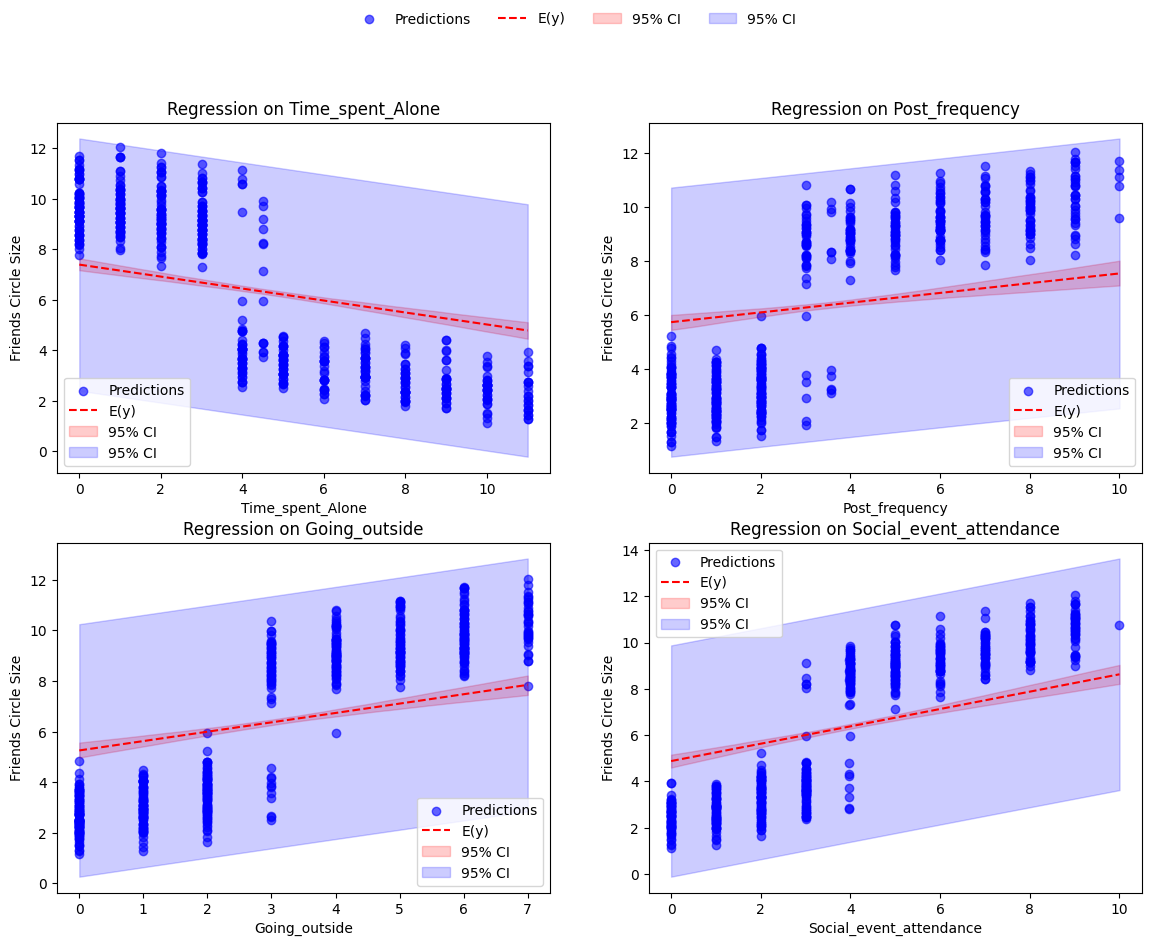

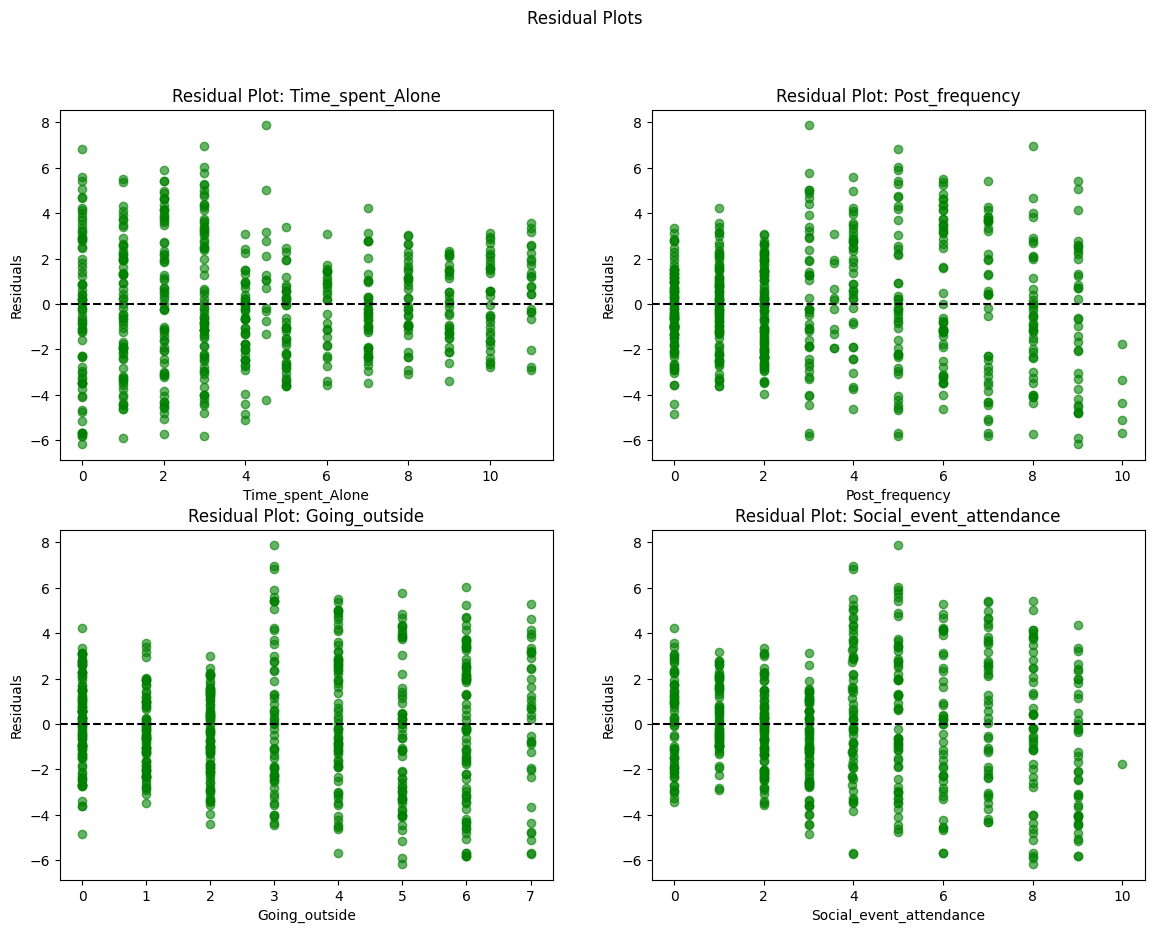

In [209]:
# Create subplots for prediction and residuals
fig_preds, axs_preds = plt.subplots(2, 2, figsize=(14, 10))
fig_resid, axs_resid = plt.subplots(2, 2, figsize=(14, 10))

axs_preds = axs_preds.flatten()
axs_resid = axs_resid.flatten()

for i, predictor in enumerate(predictors[:-1]):
    ax_pred = axs_preds[i]
    ax_resid = axs_resid[i]

    transformed_df = pre_df.copy()[predictors]
    X = transformed_df
    y = pre_df['Friends_circle_size']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1863)

    x_vals = np.linspace(X_test[predictor].min(), X_test[predictor].max(), 100)

    # "All else being equal" - fix data for other predictors
    fixed_data = pd.DataFrame({
        col: [X_test[col].mean()] * len(x_vals) if col != predictor else x_vals
        for col in predictors
    })

    # Train Ridge model
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)

    # Predictions for plotting
    y_pred = model.predict(X_test)

    # --- Plot predictions ---
    # Plot predicted values
    ax_pred.scatter(
        X_test[predictor],
        y_pred,
        alpha=0.6,
        color='blue',
        label='Predictions'
    )

    # Get predictions over a range for the regression line
    y_hat = model.predict(fixed_data)

    # Plot regression line
    ax_pred.plot(x_vals, y_hat, color='red', label='E(y)', linestyle='--')

    # Plot confidence interval
    ci_lower, ci_upper = ridge_bootstrap(X_train, y_train, fixed_data)
    ax_pred.fill_between(x_vals, ci_lower, ci_upper, color='red', alpha=0.2, label='95% CI')

    # Plot prediction interval
    pi_lower, pi_upper = ridge_bootstrap(X_train, y_train, fixed_data, given_model=ridge_model, y_hat=y_hat, interval="prediction")
    ax_pred.fill_between(x_vals, pi_lower, pi_upper, color='blue', alpha=0.2, label='95% CI')

    ax_pred.set_title(f'Regression on {predictor}')
    ax_pred.set_xlabel(predictor)
    ax_pred.set_ylabel('Friends Circle Size')
    ax_pred.legend()

    # --- Plot residuals ---
    residuals = y_test - y_pred
    ax_resid.scatter(X_test[predictor], residuals, alpha=0.6, color='green')
    ax_resid.axhline(0, color='black', linestyle='--')
    ax_resid.set_title(f'Residual Plot: {predictor}')
    ax_resid.set_xlabel(predictor)
    ax_resid.set_ylabel('Residuals')

handles, labels = axs_preds[0].get_legend_handles_labels()
fig_preds.legend(handles, labels, loc='upper center', ncol=4, frameon=False)

fig_resid.suptitle("Residual Plots")
plt.show()


## Plot Segmented Ridge Regression with CI & PI

### Compute the Optimal Segment Breakpoints

In [210]:
import statsmodels.api as sm

def find_optimal_breakpoint(x, y, min_points=10):
    """
    Try all possible split points, and return the one that minimizes total RSS (residual sum of squares).
    """
    # Sort x in a logical order.
    x_sorted = x.sort_values().reset_index(drop=True)
    possible_splits = x_sorted[min_points:-min_points]

    best_rss = float('inf')
    best_break = None

    for split in possible_splits:
        # Split the data:
        # Left segment: x[mask], y[mask]
        # Right segment: x[~mask], y[~mask]
        mask = x < split
        if mask.sum() < min_points or (~mask).sum() < min_points:
            continue
        
        # Left segment
        model_left = sm.OLS(y[mask], sm.add_constant(x[mask])).fit()
        rss_left = np.sum(model_left.resid ** 2)

        # Right segment
        model_right = sm.OLS(y[~mask], sm.add_constant(x[~mask])).fit()
        rss_right = np.sum(model_right.resid ** 2)

        # Get the smallest residual sum of squares
        total_rss = rss_left + rss_right

        if total_rss < best_rss:
            best_rss = total_rss
            best_break = split

    return best_break

# Create empty dataframe with predictors as columns and first row filled with NA
breakpoints = pd.DataFrame(np.nan, columns=predictors, index=[1])

# Fill first row with optimal breakpoints.
for predictor in predictors:
    breakpoints[predictor] = find_optimal_breakpoint(X_test[predictor], y_pred)

breakpoints

,Time_spent_Alone,Post_frequency,Going_outside,Social_event_attendance,Personality
1,4.0,3.0,3.0,4.0,1


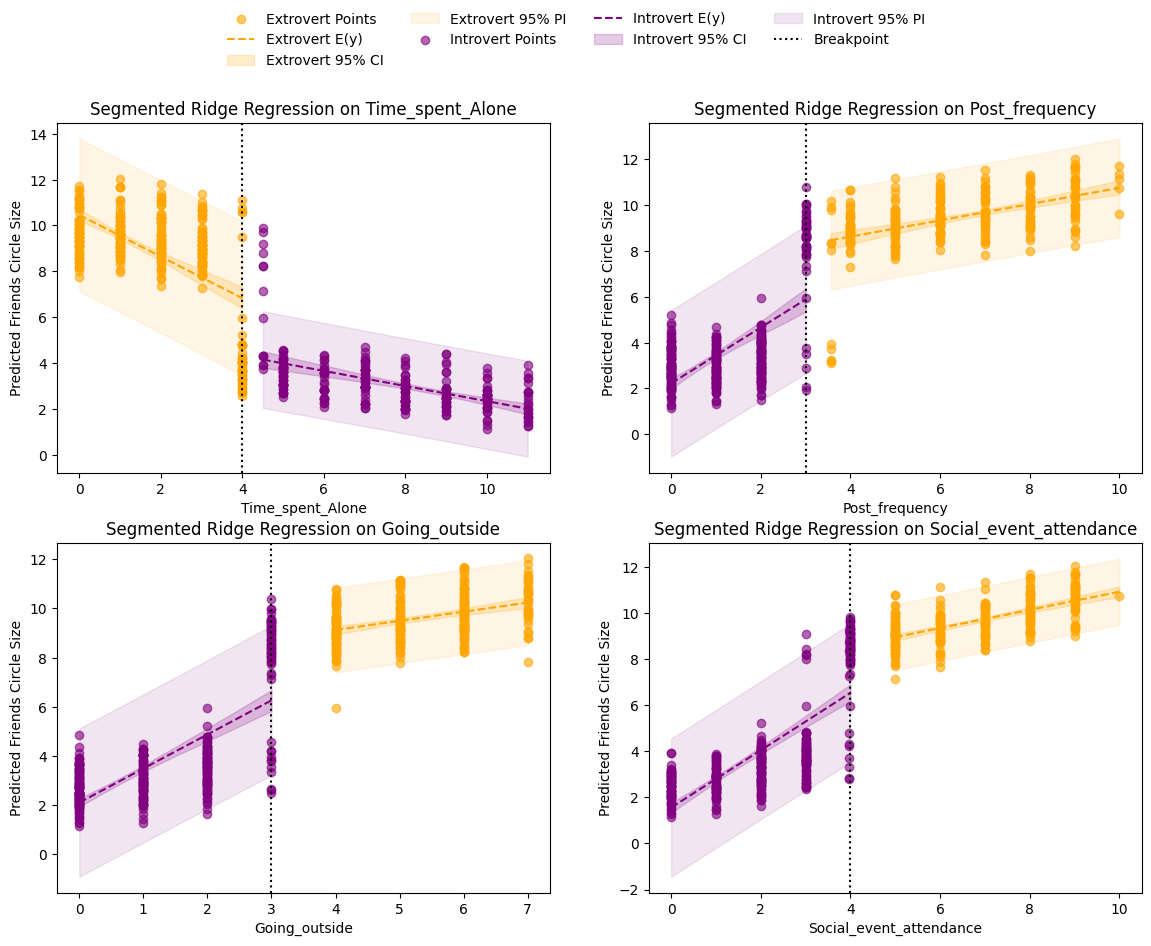

In [236]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

segments = {
    1: {
        "label": Personality.extrovert.value[1],
        "color": "orange"
    },
    0: {
        "label": Personality.introvert.value[1],
        "color": "purple"
    }
}

# L2 regularization rate
alpha = 1.0

for i, predictor in enumerate(predictors[:-1]):
    ax = axs[i]
    bp = breakpoints[predictor][1]

    # Segment masks
    low_mask = X_test[predictor] <= bp
    high_mask = X_test[predictor] > bp

    for mask in [low_mask, high_mask]:
        segment_data = X_test[mask].copy()
        X = segment_data[[predictor]].copy()
        y = y_pred[mask].copy()

        # Fit ridge model
        model = Ridge(alpha=alpha)
        model.fit(X, y)

        # Generate range of x values for predictions
        x_vals = np.linspace(X[predictor].min(), X[predictor].max(), 100).reshape(-1, 1)
        x_vals_df = pd.DataFrame(x_vals, columns=[predictor])

        y_hat = model.predict(x_vals_df)

        ci_lower, ci_upper = ridge_bootstrap(
            X,
            y,
            fixed_data=x_vals_df,
            interval="confidence"
        )

        pi_lower, pi_upper = ridge_bootstrap(
            X,
            y,
            fixed_data=x_vals_df,
            given_model=model,
            y_hat=y_hat,
            interval="prediction",
        )

        # Get personality for color/label
        personality = segment_data["Personality"].mode()[0]
        color = segments[personality]["color"]
        label = segments[personality]["label"]

        # Plot data points
        ax.scatter(
            X[predictor],
            y,
            alpha=0.6,
            color=color,
            label=f"{label} Points"
        )

        # Plot regression line
        ax.plot(
            x_vals,
            y_hat,
            color=color,
            linestyle='--',
            label=f'{label} E(y)'
        )

        # Confidence interval
        ax.fill_between(
            x_vals.ravel(),
            ci_lower,
            ci_upper,
            color=color,
            alpha=0.2,
            label=f'{label} 95% CI'
        )

        # Prediction interval
        ax.fill_between(
            x_vals.ravel(),
            pi_lower,
            pi_upper,
            color=color,
            alpha=0.1,
            label=f'{label} 95% PI'
        )

    ax.axvline(bp, color='black', linestyle=':', label='Breakpoint')
    ax.set_title(f'Segmented Ridge Regression on {predictor}')
    ax.set_xlabel(predictor)
    ax.set_ylabel('Predicted Friends Circle Size')

# Avoid duplicate legends
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, frameon=False)
plt.show()

# Prediction
---

In [237]:
from numpy import median

column_range: dict[str, dict[ str, int | float]] = {}
for column in predictors:
    column_range[column] = {
        "max": max(pre_df[column]),
        "median": median(pre_df[column]),
        "min": min(pre_df[column])
    }

In [238]:
B = ridge_model.coef_
B_df = pd.DataFrame(index=X_train.columns, data=B, columns=["Coefficient"])
B_df.to_csv("../data/coefficient_dataframe.csv")

def estimate(x, idx):
    coefficient: float = B[idx]
    proportion: float = x / column_range[X_train.columns[idx]]["max"]
    return coefficient * proportion

time_alone = lambda x: estimate(x, 1)
post_freq = lambda x: estimate(x, 2)
outside = lambda x: estimate(x, 3)
events = lambda x: estimate(x, 4)

y = time_alone(1) + post_freq(5) + outside(10) + events(10)
y

np.float64(12.358762217199551)

# Application
---

In [239]:
%%writefile app.py
import streamlit as st
from numpy import median
import pandas as pd

st.title("Friend Circle Size Estimator")
st.markdown(
    """ 
    This app allows for educators to estimate the number a friends a student may have based on
    self-reported time spent alone, posting online, going outside, attending events, and
    attending outside events.
    """
)

pre_df = pd.read_csv("data/preprocessing_dataframe.csv")
predictors = ["Time_spent_Alone", "Post_frequency", "Going_outside", "Social_event_attendance"]
column_range: dict[str, dict[str, int | float]] = {}
for column in predictors:
    column_range[column] = {
        "max": max(pre_df[column]),
        "median": median(pre_df[column]),
        "min": min(pre_df[column])
    }

result = {}
for column in predictors:
    humanized_label: str = ' '.join(column.lower().split('_')).capitalize()
    value = st.slider(
        humanized_label,
        min_value=column_range[column]["min"],
        max_value=column_range[column]["max"],
        value=column_range[column]["median"]
    )
    result[column] = value

coef_df = pd.read_csv("data/coefficient_dataframe.csv", index_col=0)


def estimate(x, column):
    coefficient: float = coef_df.loc[column]
    proportion: float = x / column_range[column]["max"]
    return coefficient * proportion


def get_estimate():
    estimated = 0.0
    for column in predictors:
        estimated += estimate(result[column], column)
    return round(estimated.loc["Coefficient"], 2)


if st.button("Estimate"):
    st.text("{} friends".format(get_estimate()))


Overwriting app.py
